In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image 
import cv2 
from random import shuffle
import glob
import tables
import cv2
from math import ceil


In [3]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
# fileslist = [f for f in os.listdir("./blue/left") if f.endswith('.jpg')]
# img = Image.open('./blue/left/'+fileslist[0])

# c = 100
# for i in fileslist:
#     img = Image.open('./blue/left/'+i)
#     image_arr = np.array(img) 
#     # image_arr = cv2.GaussianBlur(image_arr, (101, 101), 0)
#     image_1 = image_arr[0:320,0:480] 
#     image_2 = image_arr[0:320,480:960]
#     image_3 = image_arr[0:320,960:1440]
#     image_1 = Image.fromarray(image_1)
#     image_2 = Image.fromarray(image_2)
#     image_3 = Image.fromarray(image_3)
#     image_1.save("./blue/train/cone/"+str(c)+'.jpg')
#     image_3.save("./blue/train/none/"+str(c+1)+'.jpg')
#     image_2.save("./blue/train/none/"+str(c+2)+'.jpg')
#     c+=3


In [4]:
shuffle_data = True  # shuffle the addresses before saving
hdf5_path = './blue/dataset.hdf5'  # address to where you want to save the hdf5 file
train_path = './blue/train/*/*.jpg' # path of the directory where image data is stored.
data_order = 'tf' # different library uses different data ordering `tf` is used for tensor flow.

In [5]:
addrs = glob.glob(train_path)
labels = [0 if 'none' in addr else 1 for addr in addrs]

In [7]:
if shuffle_data:
    c = list(zip(addrs, labels))
    shuffle(c)
    addrs, labels = zip(*c)

In [8]:
train_addrs = addrs[0:int(0.6*len(addrs))]
train_labels = labels[0:int(0.6*len(labels))]

val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]

test_addrs = addrs[int(0.8*len(addrs)):]
test_labels = labels[int(0.8*len(labels)):]
print('train size:',len(train_addrs))
print('val size:',len(val_addrs))
print('test size:',len(test_addrs))

train size: 135
val size: 45
test size: 45


In [ ]:
data_order = 'tf'  # 'th' for Theano, 'tf' for Tensorflow
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved

# check the order of data and chose proper data shape to save images
if data_order == 'th':
    data_shape = (0, 3, 256, 256)
elif data_order == 'tf':
    data_shape = (0, 256, 256, 3)

# open a hdf5 file and create earrays
hdf5_file = tables.open_file(hdf5_path, mode='w')
try:
    train_storage = hdf5_file.create_earray(hdf5_file.root, 'train_img', img_dtype, shape=data_shape)
    val_storage = hdf5_file.create_earray(hdf5_file.root, 'val_img', img_dtype, shape=data_shape)
    test_storage = hdf5_file.create_earray(hdf5_file.root, 'test_img', img_dtype, shape=data_shape)
    
    mean_storage = hdf5_file.create_earray(hdf5_file.root, 'train_mean', img_dtype, shape=data_shape)
    
    # create the label arrays and copy the labels data in them
    hdf5_file.create_array(hdf5_file.root, 'train_labels', train_labels)
    hdf5_file.create_array(hdf5_file.root, 'val_labels', val_labels)
    hdf5_file.create_array(hdf5_file.root, 'test_labels', test_labels)
    
    # a numpy array to save the mean of the images
    mean = np.zeros(data_shape[1:], np.float32)
    
    # loop over train addresses
    for i in range(len(train_addrs)):
        # print how many images are saved every 100 images
        if i % 10 == 0 and i > 1:
            print('Train data: {}/{}'.format(i, len(train_addrs)))
    
        # read an image and resize to (224, 224)
        # cv2 load images as BGR, convert it to RGB
        addr = train_addrs[i]
        #print(addr)
        img = cv2.imread(addr)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        # add any image pre-processing here
    
        # if the data order is Theano, axis orders should change
        if data_order == 'th':
            img = np.rollaxis(img, 2)
    
        # save the image and calculate the mean so far
        train_storage.append(img[None])
        mean += img / float(len(train_labels))
    
    # loop over validation addresses
    for i in range(len(val_addrs)):
        # print how many images are saved every 1000 images
        if i % 10 == 0 and i > 1:
            print ('Validation data: {}/{}'.format(i, len(val_addrs)))
    
        # read an image and resize to (256, 256)
        # cv2 load images as BGR, convert it to RGB
        addr = val_addrs[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        # add any image pre-processing here
    
        # if the data order is Theano, axis orders should change
        if data_order == 'th':
            img = np.rollaxis(img, 2)
    
        # save the image
        val_storage.append(img[None])
    
    # loop over test addresses
    for i in range(len(test_addrs)):
        # print how many images are saved every 1000 images
        if i % 10 == 0 and i > 1:
            print ('Test data: {}/{}'.format(i, len(test_addrs)))
    
        # read an image and resize to (224, 224)
        # cv2 load images as BGR, convert it to RGB
        addr = test_addrs[i]
        #print(addr)
        img = cv2.imread(addr)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        # add any image pre-processing here
    
        # if the data order is Theano, axis orders should change
        if data_order == 'th':
            img = np.rollaxis(img, 2)
    
        # save the image
        test_storage.append(img[None])
    
    # save the mean and close the hdf5 file
    mean_storage.append(mean[None])
    print('HDF5 Done')
finally:
    print('In Finally')
    hdf5_file.close()

Train data: 10/135
Train data: 20/135
Train data: 30/135
Train data: 40/135
Train data: 50/135
Train data: 60/135
Train data: 70/135
Train data: 80/135
Train data: 90/135
Train data: 100/135
Train data: 110/135
Train data: 120/135
Train data: 130/135
Validation data: 10/45
Validation data: 20/45
Validation data: 30/45
Validation data: 40/45
Test data: 10/45
Test data: 20/45
Test data: 30/45
Test data: 40/45
HDF5 Done
In Finally


In [ ]:
hdf5_path = './blue/dataset.hdf5'  # Path where dataset.hdf5 file is stored
subtract_mean = True
batch_size = 50
nb_class = 2

In [ ]:
hdf5_file = tables.open_file(hdf5_path, mode='r')
# subtract the training mean
if subtract_mean:
    mm = hdf5_file.root.train_mean[0]
    mm = mm[np.newaxis, ...]

# Total number of samples
train_data = np.array(hdf5_file.root.train_img)
train_label = np.array(hdf5_file.root.train_labels)

test_data = np.array(hdf5_file.root.test_img)
test_label = np.array(hdf5_file.root.test_labels)

val_data = np.array(hdf5_file.root.val_img)
val_label = np.array(hdf5_file.root.val_labels)

print('train data:',train_data.shape,' train_label',train_label.shape)
print('test_data:',test_data.shape,' test_label:',test_label.shape)
print('val_data:',val_data.shape,' val_label:',val_label.shape)

train data: (135, 256, 256, 3)  train_label (135,)
test_data: (45, 256, 256, 3)  test_label: (45,)
val_data: (45, 256, 256, 3)  val_label: (45,)


In [ ]:
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(train_label))
train_label = to_categorical(train_label, num_classes)
test_label = to_categorical(test_label, num_classes)
val_label = to_categorical(val_label, num_classes)

# print shape of training set
print('num_classes:', num_classes)

# print number of training, validation, and test images
print(train_label.shape, 'train samples')
print(test_label.shape, 'test samples')
print(val_label.shape, 'validation samples')

num_classes: 2
(135, 2) train samples
(45, 2) test samples
(45, 2) validation samples


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(256, 256, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='tanh'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='tanh'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      208       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 512)              

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='selu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 flatten_5 (Flatten)         (None, 230400)           

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='model.weights.best_200.hdf5', verbose=1, 
                               save_best_only=True,monitor='val_accuracy', mode = "max")
hist = model.fit(train_data, train_label, batch_size=None, epochs=200,
          validation_data=(val_data, val_label),callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: 90.3616 - accuracy: 0.6148
Epoch 1: val_accuracy improved from -inf to 0.68889, saving model to model.weights.best_200.hdf5
5/5 [==============================] - 6s 1s/step - loss: 90.3616 - accuracy: 0.6148 - val_loss: 20.6461 - val_accuracy: 0.6889
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 7.8071 - accuracy: 0.7704
Epoch 2: val_accuracy improved from 0.68889 to 0.97778, saving model to model.weights.best_200.hdf5
5/5 [==============================] - 10s 2s/step - loss: 7.8071 - accuracy: 0.7704 - val_loss: 0.0410 - val_accuracy: 0.9778
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8667
Epoch 3: val_accuracy improved from 0.97778 to 1.00000, saving model to model.weights.best_200.hdf5
5/5 [==============================] - 8s 1s/step - loss: 0.4298 - accuracy: 0.8667 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 4/200
5/5 [=========================

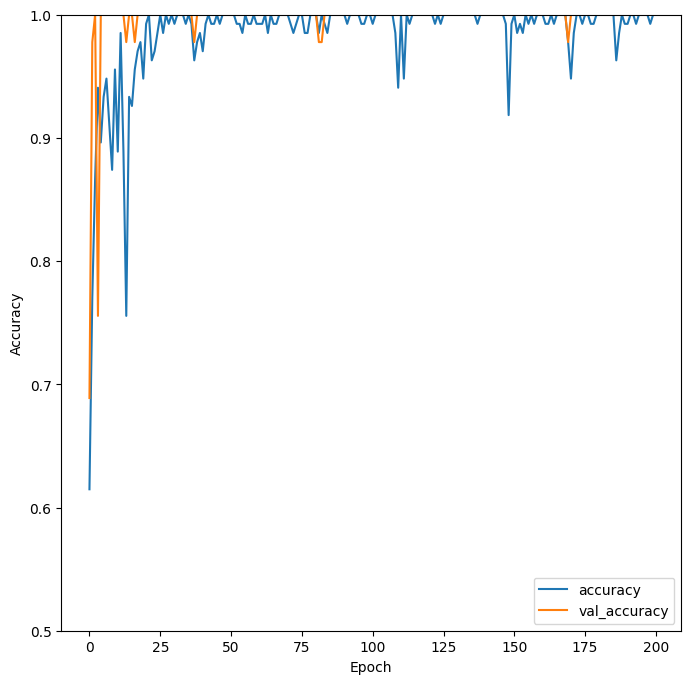

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.savefig("output_report.png")

In [ ]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(test_data, test_label, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 1.0


In [ ]:
tf.version.VERSION

'2.13.1'

In [ ]:
x = 3
a = model.predict(np.expand_dims(test_data[x], axis=0))
print(a[0])
score = tf.nn.softmax(a[0])
print(score)
img = Image.fromarray(test_data[x])
img.show()

1/1 [==============================] - 0s 41ms/step
[1. 0.]
tf.Tensor([0.7310586  0.26894143], shape=(2,), dtype=float32)


In [ ]:
x = 10
a = model.predict(np.expand_dims(test_data[x], axis=0))
print(a[0])
score = tf.nn.softmax(a[0])
print(score)
img = Image.fromarray(test_data[x])
img.show()

1/1 [==============================] - 0s 28ms/step
[0. 1.]
tf.Tensor([0.26894143 0.7310586 ], shape=(2,), dtype=float32)
